In [ ]:
import os
import time
import pickle
from itertools import product, combinations
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction & Clustering
from umap import UMAP
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLP - Gensim
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# NLP - NLTK
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet

# NLP - BERTopic & Transformers
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/agastyaharta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agastyaharta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LDA

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df_docs = pd.read_csv("data_cleaned/dostoevsky_chunks.csv")
# df_docs = pd.read_csv("/content/drive/MyDrive/wne_uw/3/project/text_mining_final/text_mining_topic_modelling/data_cleaned/dostoevsky_chunks.csv")
df_docs.head(4)
df_docs.info()

<class 'pandas.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   book_id      4787 non-null   str  
 1   chunk_index  4787 non-null   int64
 2   chunk_id     4787 non-null   str  
 3   text_base    4787 non-null   str  
 4   text_lda     4787 non-null   str  
 5   text_bert    4787 non-null   str  
dtypes: int64(1), str(5)
memory usage: 21.9 MB


In [ ]:
vectorizer = CountVectorizer(
    min_df=15,
    max_df=0.95
)

dtm = vectorizer.fit_transform(df_docs["text_lda"])
vocab = vectorizer.get_feature_names_out()

print("dtm shape:", dtm.shape)

dtm shape: (4787, 4247)


In [ ]:
print("n_docs:", dtm.shape[0])
print("vocab_size:", dtm.shape[1])

n_docs: 4787
vocab_size: 4247


In [ ]:
k = 20
lda = LatentDirichletAllocation(
    n_components=k,
    random_state=1881
)

doc_topic = lda.fit_transform(dtm)

In [ ]:
def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_ids = np.argsort(topic)[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_ids]
        topics.append((topic_idx, top_words))
    return topics

topics = show_topics(lda, vocab, n_top_words=10)
for tid, words in topics:
    print(f"topic {tid}: {', '.join(words)}")

topic 0: think, speak, laugh, face, understand, question, right, yes, something, ask
topic 1: begin, moment, hand, answer, ilyitch, ask, without, suddenly, cry, head
topic 2: think, get, good, yes, razumihin, want, ask, dounia, petrovitch, take
topic 3: prince, lebedeff, gania, think, rogojin, quite, nastasia, much, word, evgenie
topic 4: stepanovitch, liputin, nothing, think, day, virginsky, erkel, give, without, get
topic 5: day, petrovna, take, vsyevolodovitch, trofimovitch, stepanovitch, town, petersburg, year, first
topic 6: every, church, society, people, question, begin, russian, verhovensky, yulia, mihailovna
topic 7: child, gentleman, take, dance, mavriky, girl, people, get, nikolaevitch, little
topic 8: young, lady, old, two, upon, year, room, stake, family, people
topic 9: hand, suddenly, room, face, eye, stand, away, take, begin, head
topic 10: love, think, heart, good, life, never, day, dear, perhaps, little
topic 11: father, elder, monk, day, monastery, zossima, many, gre

In [ ]:
lda_topic_cols = [f"topic_{i}" for i in range(k)]
lda_df_topic = pd.DataFrame(doc_topic, columns=lda_topic_cols)
lda_df_topic["book_id"] = df_docs["book_id"].values

lda_book_topic = lda_df_topic.groupby("book_id")[lda_topic_cols].mean()

# most prominent topic per book
top_topic = lda_book_topic.idxmax(axis=1)

print("most prominent topic per book:")
print(top_topic)

lda_book_topic

most prominent topic per book:
book_id
Crime_and_Punishment               topic_2
Notes_from_the_Underground        topic_17
Poor_Folk                         topic_19
Short_Stories                      topic_9
The_Brothers_Karamazov             topic_9
The_Gambler                       topic_19
The_Grand_Inquisitor              topic_13
The_Idiot                          topic_3
The_Possessed _or_The_Devils       topic_5
White_Nights_and_Other_Stories     topic_9
dtype: str


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
book_id,,,,,,,,,,,,,,,,,,,,
Crime_and_Punishment,0.012922,0.028046,0.315247,0.001389,0.010934,0.033363,0.008698,0.028362,0.031349,0.263436,0.064815,0.006711,0.025244,0.014557,0.009276,0.017689,0.006819,0.070860,0.041519,0.008764
Notes_from_the_Underground,0.034079,0.091297,0.062005,0.002486,0.024780,0.012839,0.010271,0.055755,0.044884,0.158756,0.087554,0.020395,0.009552,0.014306,0.019137,0.008723,0.000425,0.294920,0.029040,0.018797
Poor_Folk,0.005424,0.011513,0.008381,0.004466,0.005650,0.015666,0.003571,0.006735,0.051984,0.121845,0.291895,0.011144,0.003811,0.018000,0.006728,0.013207,0.000405,0.023440,0.026561,0.369574
Short_Stories,0.014734,0.102423,0.060816,0.001451,0.008684,0.048613,0.017843,0.077702,0.061907,0.198692,0.071428,0.021908,0.047940,0.022007,0.012273,0.011055,0.013030,0.072926,0.118397,0.016172
The_Brothers_Karamazov,0.013090,0.032282,0.038468,0.001831,0.002075,0.020038,0.019882,0.020364,0.038808,0.156189,0.130660,0.070277,0.101881,0.060910,0.117863,0.041161,0.019506,0.056142,0.053920,0.004652
The_Gambler,0.025252,0.006790,0.015442,0.011492,0.007783,0.009219,0.004505,0.008361,0.160859,0.065419,0.049392,0.004086,0.003908,0.005333,0.004132,0.016165,0.011540,0.044872,0.034586,0.510865
The_Grand_Inquisitor,0.018989,0.006729,0.008018,0.001858,0.002762,0.000374,0.000915,0.004386,0.025509,0.059950,0.015080,0.011359,0.013907,0.765697,0.005954,0.000374,0.001019,0.049276,0.004530,0.003314
The_Idiot,0.042531,0.024213,0.016948,0.408546,0.005182,0.016761,0.009753,0.014386,0.053645,0.098066,0.084362,0.007253,0.010786,0.012177,0.007767,0.093043,0.021404,0.042468,0.021326,0.009382
The_Possessed _or_The_Devils,0.023433,0.032054,0.075868,0.002698,0.057370,0.168042,0.087829,0.038896,0.043924,0.132462,0.067959,0.011600,0.013739,0.015093,0.019151,0.016965,0.106749,0.058487,0.022062,0.005621


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(lda_book_topic.values)
lda_book_sim = pd.DataFrame(sim, index=lda_book_topic.index, columns=lda_book_topic.index)

lda_book_sim

book_id,Crime_and_Punishment,Notes_from_the_Underground,Poor_Folk,Short_Stories,The_Brothers_Karamazov,The_Gambler,The_Grand_Inquisitor,The_Idiot,The_Possessed _or_The_Devils,White_Nights_and_Other_Stories
book_id,,,,,,,,,,
Crime_and_Punishment,1.000000,0.599190,0.298761,0.735590,0.608148,0.175419,0.108716,0.246163,0.630794,0.741262
Notes_from_the_Underground,0.599190,1.000000,0.352104,0.745073,0.623024,0.240708,0.138748,0.278482,0.563708,0.823134
Poor_Folk,0.298761,0.352104,1.000000,0.418030,0.470143,0.828321,0.078750,0.221523,0.326431,0.574597
Short_Stories,0.735590,0.745073,0.418030,1.000000,0.788111,0.274190,0.161989,0.316834,0.712876,0.860025
The_Brothers_Karamazov,0.608148,0.623024,0.470143,0.788111,1.000000,0.207882,0.288016,0.323496,0.613889,0.797160
The_Gambler,0.175419,0.240708,0.828321,0.274190,0.207882,1.000000,0.042250,0.143143,0.195640,0.275630
The_Grand_Inquisitor,0.108716,0.138748,0.078750,0.161989,0.288016,0.042250,1.000000,0.064594,0.117345,0.123312
The_Idiot,0.246163,0.278482,0.221523,0.316834,0.323496,0.143143,0.064594,1.000000,0.278142,0.351497
The_Possessed _or_The_Devils,0.630794,0.563708,0.326431,0.712876,0.613889,0.195640,0.117345,0.278142,1.000000,0.660505


In [ ]:
threshold =

topic_breadth = (lda_book_topic > threshold).sum(axis=0)
topic_breadth_pct = topic_breadth / lda_book_topic.shape[0]

lda_recurrence = pd.DataFrame({
    "topic": topic_breadth.index,
    "n_books": topic_breadth.values,
    "pct_books": topic_breadth_pct.values
}).sort_values("n_books", ascending=False)

print("Topic recurrence across books (threshold =", threshold, "):")
print(lda_recurrence)


print("\nTop 5 most recurrent topics:")
print(lda_recurrence.head(5))

Topic recurrence across books (threshold = 0.05 ):
       topic  n_books  pct_books
9    topic_9       10        1.0
10  topic_10        8        0.8
17  topic_17        6        0.6
8    topic_8        5        0.5
2    topic_2        5        0.5
1    topic_1        3        0.3
18  topic_18        2        0.2
13  topic_13        2        0.2
19  topic_19        2        0.2
7    topic_7        2        0.2
6    topic_6        1        0.1
11  topic_11        1        0.1
12  topic_12        1        0.1
5    topic_5        1        0.1
14  topic_14        1        0.1
15  topic_15        1        0.1
16  topic_16        1        0.1
4    topic_4        1        0.1
3    topic_3        1        0.1
0    topic_0        0        0.0

Top 5 most recurrent topics:
       topic  n_books  pct_books
9    topic_9       10        1.0
10  topic_10        8        0.8
17  topic_17        6        0.6
8    topic_8        5        0.5
2    topic_2        5        0.5


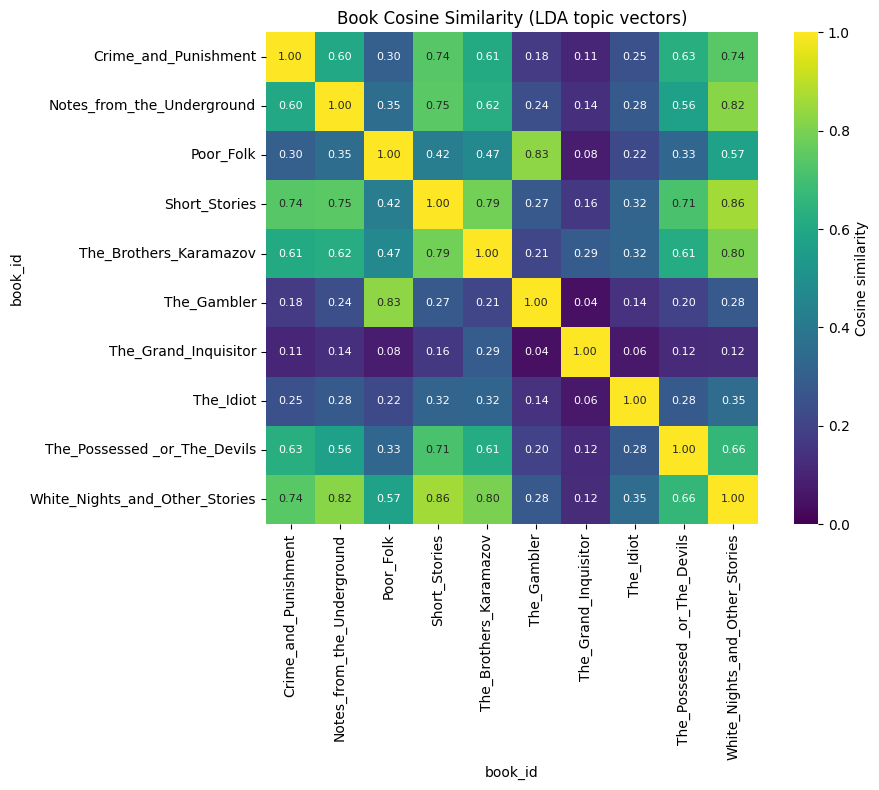

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    lda_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cosine similarity"},
    annot=True,
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)
plt.title("Book Cosine Similarity (LDA topic vectors)")
plt.xlabel("book_id")
plt.ylabel("book_id")
plt.tight_layout()
plt.show()

In [ ]:
lda_analyzer = vectorizer.build_analyzer()
lda_texts = df_docs["text_lda"].astype(str).tolist()
lda_tokens = [lda_analyzer(t) for t in lda_texts]

lda_dictionary = Dictionary(lda_tokens)
lda_corpus = [lda_dictionary.doc2bow(toks) for toks in lda_tokens]

def lda_top_words(lda_model, vocab, topn=10):
    topic_words = []
    for k in range(lda_model.components_.shape[0]):
        comp = lda_model.components_[k]
        top_ids = np.argsort(comp)[::-1][:topn]
        topic_words.append([vocab[i] for i in top_ids])
    return topic_words

lda_topic_words_10 = lda_top_words(lda, vocab, topn=10)

coh_npmi = CoherenceModel(topics=lda_topic_words_10, texts=lda_tokens,
                          dictionary=lda_dictionary, coherence="c_npmi")
coh_uci  = CoherenceModel(topics=lda_topic_words_10, texts=lda_tokens,
                          dictionary=lda_dictionary, coherence="c_uci")
coh_umass = CoherenceModel(topics=lda_topic_words_10, corpus=lda_corpus,
                           dictionary=lda_dictionary, coherence="u_mass")

lda_quality = pd.DataFrame({
    "topic_id": range(len(lda_topic_words_10)),
    "coh_npmi": coh_npmi.get_coherence_per_topic(),
    "coh_uci": coh_uci.get_coherence_per_topic(),
    "coh_umass": coh_umass.get_coherence_per_topic(),
    "top_words": [", ".join(ws) for ws in lda_topic_words_10]
}).sort_values("coh_npmi", ascending=False)

lda_quality.head(10)


,topic_id,coh_npmi,coh_uci,coh_umass,top_words
13,13,0.159922,1.369854,-1.907274,"god, thou, earth, men, world, great, thee, sin..."
18,18,0.128004,0.819519,-0.957955,"rouble, money, thousand, give, hundred, three,..."
11,11,0.105950,0.861103,-1.643062,"father, elder, monk, day, monastery, zossima, ..."
3,3,0.089500,0.692908,-1.482198,"prince, lebedeff, gania, think, rogojin, quite..."
12,12,0.079717,0.676331,-1.602638,"murder, doctor, evidence, kill, prosecutor, pr..."
5,5,0.047087,0.386205,-1.665049,"day, petrovna, take, vsyevolodovitch, trofimov..."
4,4,0.036553,0.307332,-1.504758,"stepanovitch, liputin, nothing, think, day, vi..."
2,2,0.036227,0.278631,-1.697752,"think, get, good, yes, razumihin, want, ask, d..."
16,16,0.034041,-0.068700,-1.628716,"trofimovitch, petrovna, room, sit, house, sudd..."
9,9,0.031115,0.198272,-1.057625,"hand, suddenly, room, face, eye, stand, away, ..."


In [ ]:
lda_avg = lda_quality[["coh_umass", "coh_uci", "coh_npmi"]].mean()
print("LDA average coherence scores:")
print(lda_avg)

LDA average coherence scores:
coh_umass   -1.674288
coh_uci      0.128767
coh_npmi     0.040347
dtype: float64


In [ ]:
def topic_diversity(topic_words, topn=10):
    words = [w for topic in topic_words for w in topic[:topn]]
    return len(set(words)) / (len(topic_words) * topn)

lda_diversity_10 = topic_diversity(lda_topic_words_10, topn=10)
print("LDA topic diversity for top 10 words:", lda_diversity_10)

LDA topic diversity for top 10 words: 0.645


In [ ]:
lda_phi = lda.components_.astype(float)
lda_phi = lda_phi / lda_phi.sum(axis=1, keepdims=True)

K = lda_phi.shape[0]
lda_jsd = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        lda_jsd[i, j] = jensenshannon(lda_phi[i], lda_phi[j])  # distance in [0, 1]

lda_jsd_df = pd.DataFrame(
    lda_jsd,
    index=[f"topic_{i}" for i in range(K)],
    columns=[f"topic_{i}" for i in range(K)]
)

pairs = []
for i in range(K):
    for j in range(i+1, K):
        pairs.append((i, j, lda_jsd[i, j]))
pairs.sort(key=lambda x: x[2])

print("Most similar (potentially redundant) LDA topic pairs (smallest JSD distance):")
for i, j, d in pairs[:10]:
    print(f"topic_{i} vs topic_{j}: JSD={d:.4f}")


Most similar (potentially redundant) LDA topic pairs (smallest JSD distance):
topic_2 vs topic_9: JSD=0.4514
topic_9 vs topic_15: JSD=0.4576
topic_9 vs topic_16: JSD=0.4618
topic_2 vs topic_10: JSD=0.4655
topic_1 vs topic_9: JSD=0.4659
topic_1 vs topic_2: JSD=0.4688
topic_2 vs topic_15: JSD=0.4712
topic_10 vs topic_14: JSD=0.4768
topic_2 vs topic_3: JSD=0.4862
topic_10 vs topic_17: JSD=0.4877


# BERT

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

texts = df_docs["text_bert"].astype(str).tolist()

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
stop_words |= {
    "said","say","tell","would","could","must","shall","one","though","even","well","like",
    "know","come","look","see","go","make","man","time"
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
embedding_model.max_seq_length = 512

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

tokenizer = RegexpTokenizer(r"\w+")
tf_vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    min_df=15,
    max_df=0.95,
    tokenizer=tokenizer.tokenize,
    stop_words=list(stop_words)
)

ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

topic_model_bert = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    top_n_words=10,
    calculate_probabilities=True,
    nr_topics=20
)

topics, probabilities = topic_model_bert.fit_transform(texts)

topic_model_bert.get_topic_info()

Using device: cpu


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1677,-1_suddenly_moment_words_thought,"[suddenly, moment, words, thought, end, mind, ...","[back with her eyes starting out of her head, ..."
1,0,1536,0_love_words_much_suddenly,"[love, words, much, suddenly, almost, god, ano...","[his friend turned his back, he came up softly..."
2,1,534,1_happened_words_suddenly_get,"[happened, words, suddenly, get, afterwards, k...",[the story had got about so quickly and so acc...
3,2,429,2_feel_suddenly_end_much,"[feel, suddenly, end, much, upon, thought, mom...",[and visited my neighbors much less frequently...
4,3,243,3_words_afterwards_suddenly_god,"[words, afterwards, suddenly, god, much, leave...",[the old man out of his mind.... do you rememb...
5,4,114,4_god_end_upon_words,"[god, end, upon, words, love, much, little, ca...","[what your father paissiy taught you?"" ""no, no..."
6,5,76,5_words_god_believe_upon,"[words, god, believe, upon, much, feel, though...",[grew more and more marked. both the superinte...
7,6,35,6_happened_mother_moment_part,"[happened, mother, moment, part, came, another...","[no, i don t want it to belong to both of us, ..."
8,7,34,7_thinking_mind_understand_end,"[thinking, mind, understand, end, upon, life, ...","[will, that all they are concerned with is tha..."
9,8,31,8_much_turned_kept_get,"[much, turned, kept, get, end, give, little, s...","[late! he is going to spin again! stake, stake..."


In [ ]:
topic_info = topic_model_bert.get_topic_info()
topic_info.head(10)

for tid in topic_info.Topic[topic_info.Topic != -1]:
    words = [w for w, _ in topic_model_bert.get_topic(tid)]
    print(f"topic {tid}: {', '.join(words[:10])}")

topic 0: love, words, much, suddenly, almost, god, another, moment, good, came
topic 1: happened, words, suddenly, get, afterwards, kept, came, understand, course, second
topic 2: feel, suddenly, end, much, upon, thought, moment, love, came, word
topic 3: words, afterwards, suddenly, god, much, leave, mind, love, came, good
topic 4: god, end, upon, words, love, much, little, came, mother, believe
topic 5: words, god, believe, upon, much, feel, thought, speak, although, word
topic 6: happened, mother, moment, part, came, another, upon, kept, suddenly, later
topic 7: thinking, mind, understand, end, upon, life, become, think, get, matter
topic 8: much, turned, kept, get, end, give, little, suddenly, second, five
topic 9: god, upon, believe, although, thinking, speak, end, else, words, understand
topic 10: happened, suddenly, afterwards, turned, moment, came, second, looked, part, another
topic 11: words, although, upon, speaking, without, word, end, god, part, book
topic 12: kept, get, g

In [ ]:
df_assign = pd.DataFrame({
    "book_id": df_docs["book_id"].values,
    "topic_id": np.asarray(topics)
})

# drop outliers
df_assign = df_assign[df_assign["topic_id"] != -1].copy()

bert_book_topic = (
    pd.crosstab(df_assign["book_id"], df_assign["topic_id"], normalize="index")
    .sort_index(axis=1)
)

bert_book_topic.columns = [f"topic_{t}" for t in bert_book_topic.columns]

# most prominent topic per book
top_topic = bert_book_topic.idxmax(axis=1)

print("most prominent topic per book:")
print(top_topic)

bert_book_topic

most prominent topic per book:
book_id
Crime_and_Punishment              topic_0
Notes_from_the_Underground        topic_2
Poor_Folk                         topic_2
Short_Stories                     topic_0
The_Brothers_Karamazov            topic_1
The_Gambler                       topic_0
The_Grand_Inquisitor              topic_4
The_Idiot                         topic_0
The_Possessed _or_The_Devils      topic_0
White_Nights_and_Other_Stories    topic_0
dtype: str


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
book_id,,,,,,,,,,,,,,,,,,,
Crime_and_Punishment,0.885845,0.054795,0.015982,0.002283,0.009132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009132,0.015982,0.00000,0.000000,0.000000,0.000000,0.006849
Notes_from_the_Underground,0.053097,0.000000,0.752212,0.000000,0.000000,0.000000,0.000000,0.132743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00885,0.026549,0.017699,0.008850,0.000000
Poor_Folk,0.019048,0.000000,0.923810,0.000000,0.009524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Short_Stories,0.769608,0.088235,0.068627,0.000000,0.049020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02451,0.000000,0.000000,0.000000,0.000000
The_Brothers_Karamazov,0.015957,0.393617,0.026596,0.321809,0.091755,0.093085,0.046543,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
The_Gambler,0.601504,0.000000,0.165414,0.000000,0.000000,0.000000,0.000000,0.000000,0.233083,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
The_Grand_Inquisitor,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
The_Idiot,0.826000,0.014000,0.122000,0.000000,0.008000,0.012000,0.000000,0.006000,0.000000,0.004000,0.000000,0.008000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
The_Possessed _or_The_Devils,0.648393,0.287335,0.011342,0.000000,0.001890,0.000000,0.000000,0.000000,0.000000,0.009452,0.028355,0.013233,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


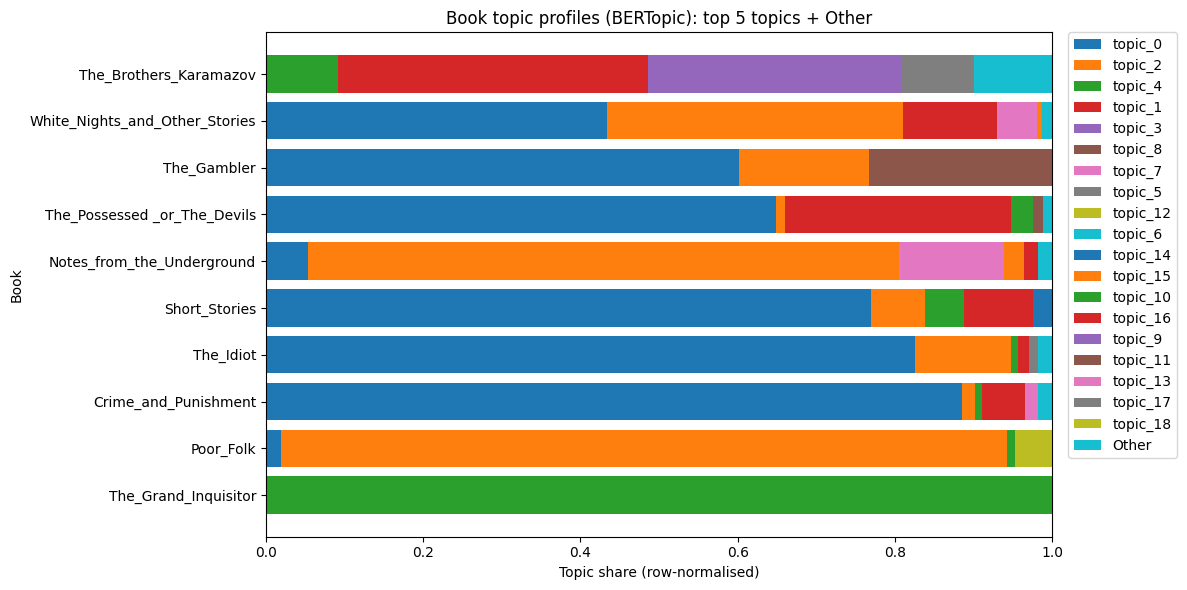

In [ ]:
df = bert_book_topic.copy()

top_k = 5

df_top = df.apply(lambda row: row.where(row.rank(ascending=False, method="first") <= top_k, 0), axis=1)
df_top["Other"] = (df.sum(axis=1) - df_top.sum(axis=1)).clip(lower=0)

book_order = df.max(axis=1).sort_values(ascending=False).index
df_top = df_top.loc[book_order]

topic_cols = [c for c in df_top.columns if c != "Other"]
topic_cols_sorted = df[topic_cols].sum(axis=0).sort_values(ascending=False).index.tolist()
df_top = df_top[topic_cols_sorted + ["Other"]]

fig, ax = plt.subplots(figsize=(12, 6))
left = np.zeros(len(df_top))

for col in df_top.columns:
    ax.barh(df_top.index, df_top[col].values, left=left, label=col)
    left += df_top[col].values

ax.set_xlabel("Topic share (row-normalised)")
ax.set_ylabel("Book")
ax.set_title(f"Book topic profiles (BERTopic): top {TOP_K} topics + Other")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

bert_book_sim = cosine_similarity(bert_book_topic.values)
bert_book_sim = pd.DataFrame(bert_book_sim, index=bert_book_topic.index, columns=bert_book_topic.index)
bert_book_sim

book_id,Crime_and_Punishment,Notes_from_the_Underground,Poor_Folk,Short_Stories,The_Brothers_Karamazov,The_Gambler,The_Grand_Inquisitor,The_Idiot,The_Possessed _or_The_Devils,White_Nights_and_Other_Stories
book_id,,,,,,,,,,
Crime_and_Punishment,1.000000,0.086778,0.039142,0.994044,0.080410,0.905550,0.010285,0.990317,0.936284,0.759238
Notes_from_the_Underground,0.086778,1.000000,0.981295,0.155144,0.051526,0.306346,0.000000,0.213100,0.078938,0.693836
Poor_Folk,0.039142,0.981295,1.000000,0.108856,0.052698,0.266584,0.010293,0.166284,0.034774,0.652910
Short_Stories,0.994044,0.155144,0.108856,1.000000,0.129560,0.913494,0.062877,0.991566,0.948816,0.806655
The_Brothers_Karamazov,0.080410,0.051526,0.052698,0.129560,1.000000,0.039806,0.173768,0.054029,0.330785,0.205023
The_Gambler,0.905550,0.306346,0.266584,0.913494,0.039806,1.000000,0.000000,0.929472,0.828753,0.824351
The_Grand_Inquisitor,0.010285,0.000000,0.010293,0.062877,0.173768,0.000000,1.000000,0.009578,0.002662,0.000000
The_Idiot,0.990317,0.213100,0.166284,0.991566,0.054029,0.929472,0.009578,1.000000,0.912408,0.826151
The_Possessed _or_The_Devils,0.936284,0.078938,0.034774,0.948816,0.330785,0.828753,0.002662,0.912408,1.000000,0.764966


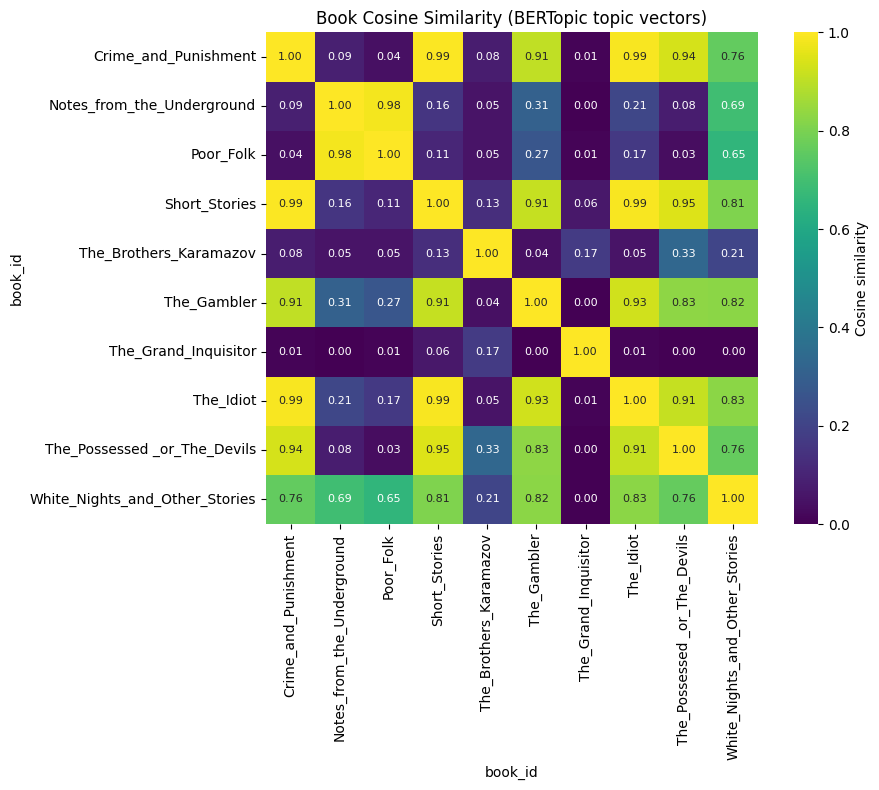

In [ ]:
plt.figure(figsize=(10, 8)) # Increased figure size for better visibility
sns.heatmap(
    bert_book_sim,
    cmap="viridis",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cosine similarity"},
    annot=True,        # Display numbers in each cell
    fmt=".2f",         # Format numbers to two decimal places
    annot_kws={"size": 8} # Adjust font size of annotations
)
plt.title("Book Cosine Similarity (BERTopic topic vectors)")
plt.xlabel("book_id")
plt.ylabel("book_id")
plt.tight_layout()
plt.show()

In [ ]:
# topic ids excluding outlier -1
bert_topic_ids = [t for t in topic_model_bert.get_topic_info().Topic.tolist() if t != -1]

# top words per topic
def bert_top_words(topic_model, topic_ids, topn=10):
    out = []
    for tid in topic_ids:
        out.append([w for w, _ in topic_model.get_topic(tid)[:topn]])
    return out

bert_topic_words_10 = bert_top_words(topic_model_bert, bert_topic_ids, topn=10)

# Tokenise documents with the fitted vectorizer inside BERTopic
bert_vectorizer = topic_model_bert.vectorizer_model
bert_analyzer = bert_vectorizer.build_analyzer()

bert_texts = df_docs["text_bert"].astype(str).tolist()
bert_tokens = [bert_analyzer(t) for t in bert_texts]

bert_dictionary = Dictionary(bert_tokens)
bert_corpus = [bert_dictionary.doc2bow(toks) for toks in bert_tokens]

# Coherence per topic
bert_coh_npmi = CoherenceModel(topics=bert_topic_words_10, texts=bert_tokens,
                               dictionary=bert_dictionary, coherence="c_npmi")
bert_coh_uci  = CoherenceModel(topics=bert_topic_words_10, texts=bert_tokens,
                               dictionary=bert_dictionary, coherence="c_uci")
bert_coh_umass = CoherenceModel(topics=bert_topic_words_10, corpus=bert_corpus,
                                dictionary=bert_dictionary, coherence="u_mass")

bert_quality = pd.DataFrame({
    "topic_id": bert_topic_ids,
    "coh_npmi": bert_coh_npmi.get_coherence_per_topic(),
    "coh_uci": bert_coh_uci.get_coherence_per_topic(),
    "coh_umass": bert_coh_umass.get_coherence_per_topic(),
    "top_words": [", ".join(ws) for ws in bert_topic_words_10]
}).sort_values("coh_npmi", ascending=False)

bert_quality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,topic_id,coh_npmi,coh_uci,coh_umass,top_words
7,7,0.011653,0.089157,-1.727728,"thinking, mind, understand, end, upon, life, b..."
15,15,0.010868,0.069087,-1.672466,"much, word, understand, mind, feel, thought, q..."
5,5,0.010238,0.071326,-1.821989,"words, god, believe, upon, much, feel, thought..."
10,10,0.008453,0.040816,-1.716609,"happened, suddenly, afterwards, turned, moment..."
9,9,0.004188,0.000258,-1.962524,"god, upon, believe, although, thinking, speak,..."
14,14,0.003456,0.012386,-1.653541,"moment, feel, believe, thought, suddenly, mind..."
6,6,0.003073,0.002129,-1.688709,"happened, mother, moment, part, came, another,..."
13,13,0.002865,-0.004810,-1.691890,"happened, words, mother, thought, thinking, wo..."
17,17,0.001517,-0.002498,-1.639779,"love, mother, god, end, enough, heart, much, k..."
2,2,-0.001865,-0.033718,-1.486352,"feel, suddenly, end, much, upon, thought, mome..."


In [ ]:
bert_avg = bert_quality[["coh_umass", "coh_uci", "coh_npmi"]].mean()
print("BERTopic average coherence scores:")
print(bert_avg)

BERTopic average coherence scores:
coh_umass   -1.738366
coh_uci     -0.100839
coh_npmi    -0.002624
dtype: float64


In [ ]:
def topic_diversity(topic_words, topn=10):
    words = [w for topic in topic_words for w in topic[:topn]]
    return len(set(words)) / (len(topic_words) * topn)

bert_diversity_10 = topic_diversity(bert_topic_words_10, topn=10)
print("BERTopic topic diversity for top 10 words:", bert_diversity_10)


BERTopic topic diversity for top 10 words: 0.3


In [ ]:
topic_info = topic_model_bert.get_topic_info()
topic_info_non_out = topic_info[topic_info.Topic != -1].copy()
topic_ids = topic_info_non_out.Topic.tolist()

c_tf_idf = topic_model_bert.c_tf_idf_
A = c_tf_idf.toarray() if hasattr(c_tf_idf, "toarray") else np.asarray(c_tf_idf)

topic_order = topic_info.Topic.tolist()
keep_mask = [t != -1 for t in topic_order]
A = A[keep_mask, :]

eps = 1e-12
A = A + eps
bert_phi = A / A.sum(axis=1, keepdims=True)

K = bert_phi.shape[0]
bert_jsd = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        bert_jsd[i, j] = jensenshannon(bert_phi[i], bert_phi[j])

bert_jsd_df = pd.DataFrame(
    bert_jsd,
    index=[f"topic_{t}" for t in topic_ids],
    columns=[f"topic_{t}" for t in topic_ids]
)

pairs = []
for i in range(K):
    for j in range(i+1, K):
        pairs.append((topic_ids[i], topic_ids[j], bert_jsd[i, j]))
pairs.sort(key=lambda x: x[2])

print("Most similar (potentially redundant) BERTopic topic pairs (smallest JSD distance):")
for a, b, d in pairs[:10]:
    print(f"topic_{a} vs topic_{b}: JSD={d:.4f}")

bert_jsd_df

Most similar (potentially redundant) BERTopic topic pairs (smallest JSD distance):
topic_0 vs topic_2: JSD=0.1158
topic_0 vs topic_1: JSD=0.1250
topic_0 vs topic_3: JSD=0.1290
topic_1 vs topic_2: JSD=0.1417
topic_2 vs topic_3: JSD=0.1674
topic_1 vs topic_5: JSD=0.1723
topic_2 vs topic_5: JSD=0.1777
topic_1 vs topic_3: JSD=0.1820
topic_0 vs topic_5: JSD=0.1926
topic_0 vs topic_6: JSD=0.1971


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
topic_0,0.000000,0.124963,0.115803,0.128991,0.251936,0.192647,0.197121,0.386900,0.314449,0.377655,0.310055,0.325829,0.349087,0.358524,0.378356,0.513602,0.578868,0.562816,0.520513
topic_1,0.124963,0.000000,0.141692,0.182004,0.271829,0.172263,0.218615,0.384465,0.294137,0.374808,0.300568,0.330704,0.358111,0.346292,0.357199,0.516684,0.592703,0.576148,0.530588
topic_2,0.115803,0.141692,0.000000,0.167405,0.234428,0.177731,0.228445,0.344583,0.306309,0.360809,0.343117,0.319146,0.357120,0.357063,0.350450,0.499416,0.579687,0.539762,0.524740
topic_3,0.128991,0.182004,0.167405,0.000000,0.242237,0.220348,0.237980,0.416291,0.347942,0.396658,0.330036,0.342410,0.357267,0.400284,0.382615,0.529566,0.574641,0.549249,0.525272
topic_4,0.251936,0.271829,0.234428,0.242237,0.000000,0.228981,0.328056,0.413404,0.377513,0.334840,0.437639,0.324379,0.414051,0.419646,0.405489,0.528766,0.602584,0.533545,0.536679
topic_5,0.192647,0.172263,0.177731,0.220348,0.228981,0.000000,0.273013,0.397225,0.332390,0.346753,0.373972,0.329938,0.397436,0.344564,0.362303,0.513354,0.611211,0.544079,0.528187
topic_6,0.197121,0.218615,0.228445,0.237980,0.328056,0.273013,0.000000,0.439120,0.368861,0.425998,0.345219,0.394815,0.378460,0.381274,0.436568,0.531875,0.605133,0.600576,0.524604
topic_7,0.386900,0.384465,0.344583,0.416291,0.413404,0.397225,0.439120,0.000000,0.411711,0.426923,0.496185,0.423848,0.489210,0.487314,0.441362,0.489120,0.578556,0.600969,0.652228
topic_8,0.314449,0.294137,0.306309,0.347942,0.377513,0.332390,0.368861,0.411711,0.000000,0.442978,0.404830,0.405707,0.390235,0.452602,0.423670,0.554528,0.634240,0.622040,0.585672
topic_9,0.377655,0.374808,0.360809,0.396658,0.334840,0.346753,0.425998,0.426923,0.442978,0.000000,0.474106,0.349315,0.502700,0.491188,0.475317,0.544464,0.651006,0.606144,0.592262
